# TechNote: 相位信息提取理论和原理验证
**Date:** 2021-05-26 **Version:** 0.1 **Author:** Xiaoyun **Comments:** Initial commit

# 一、相位信息提取方法推导（相位补偿/混频法/FFT法）

基本假设： $\fbox{FFT / PFB = FIR(Window Function) + Mixer(DDC) + Downsampling}$

FFT / Polyphase Filter Bank 某一通道输出 等价于DDC

待测信号： 

$ s_1(\omega t + \phi) = e^{j\omega t + \phi}= cos(\omega t) + j sin(\omega t)$

本振信号： 

$ s_0(\omega_0 t + \phi_0) = e^{-j\omega_0 t + \phi} = cos(\omega_0 t) - j sin(\omega_0 t) $

两者相乘得到$s(t)$实现下变频：

$\bbox[#EEF, 5px, border: 2px solid red]{s(t)=}$
$ s_1(\omega t + \phi) \times s_0(\omega_0 t + \phi_0) \\= e^{jt(\omega - \omega_0) + (\phi - \phi_0)} \\\bbox[#EEF, 5px, border: 2px solid red]{ = e^{jt(\omega - \omega_0)} e^{j(\phi - \phi_0)}}$

## 相角补偿法：

$s(t)$的相角$\Phi(t)$,随时间变化：

$\Phi(t) = arctan(e^{jt(\omega - \omega_0) + (\phi - \phi_0)})\\ = (\omega - \omega_0)t + (\phi - \phi_0) $

由于$\omega-\omega_0$为常数，记为$c$. 同时，记$\phi-\phi_0$为$\Delta\phi$

原式可写为：$\Phi(t) = ct + \Delta\phi $

故：$\bbox[#EEF, 5px, border: 2px solid red]{ \Delta\phi = \Phi(t) - ct} $ 

$ct$项即位相位补偿项, 为一线性项，因为这一项已知，通过补偿（减去）这一项即可获得$\Delta\phi$

## 混频法：

因为$s(t)=e^{jt(\omega - \omega_0)} e^{j(\phi - \phi_0)}$

将其与$e^{-jt(\omega - \omega_0)}$混频得到0频信号

$s_{DC}(t) \\= e^{jt(\omega - \omega_0)} e^{jt(\phi - \phi_0)} e^{-jt(\omega - \omega_0)} \\
=e^{j(\phi - \phi_0)}$

其相角$\Phi(t) = arctan(s_{DC}) = \phi-\phi_0$

此时：记$\phi-\phi_0$为$\Delta\phi$

$\bbox[#EEF, 5px, border: 2px solid red]{\Delta\phi=arctan(s_{DC})}$

## FFT/PFB法：

### 因为FFT=FIR+Mixing(DDC)+Downsampling，故等价于混频法。
#### TODO: FFT证明

## 二、相位补偿法解调实例：
一个正弦信号r的相位被按正弦调制，得到信号s，通过分别求解相角并将两者相减，即可复原用于调制的正弦信号。
以下均使用浮点数运算。可见残差随着时间增长。*TODO误差分析*

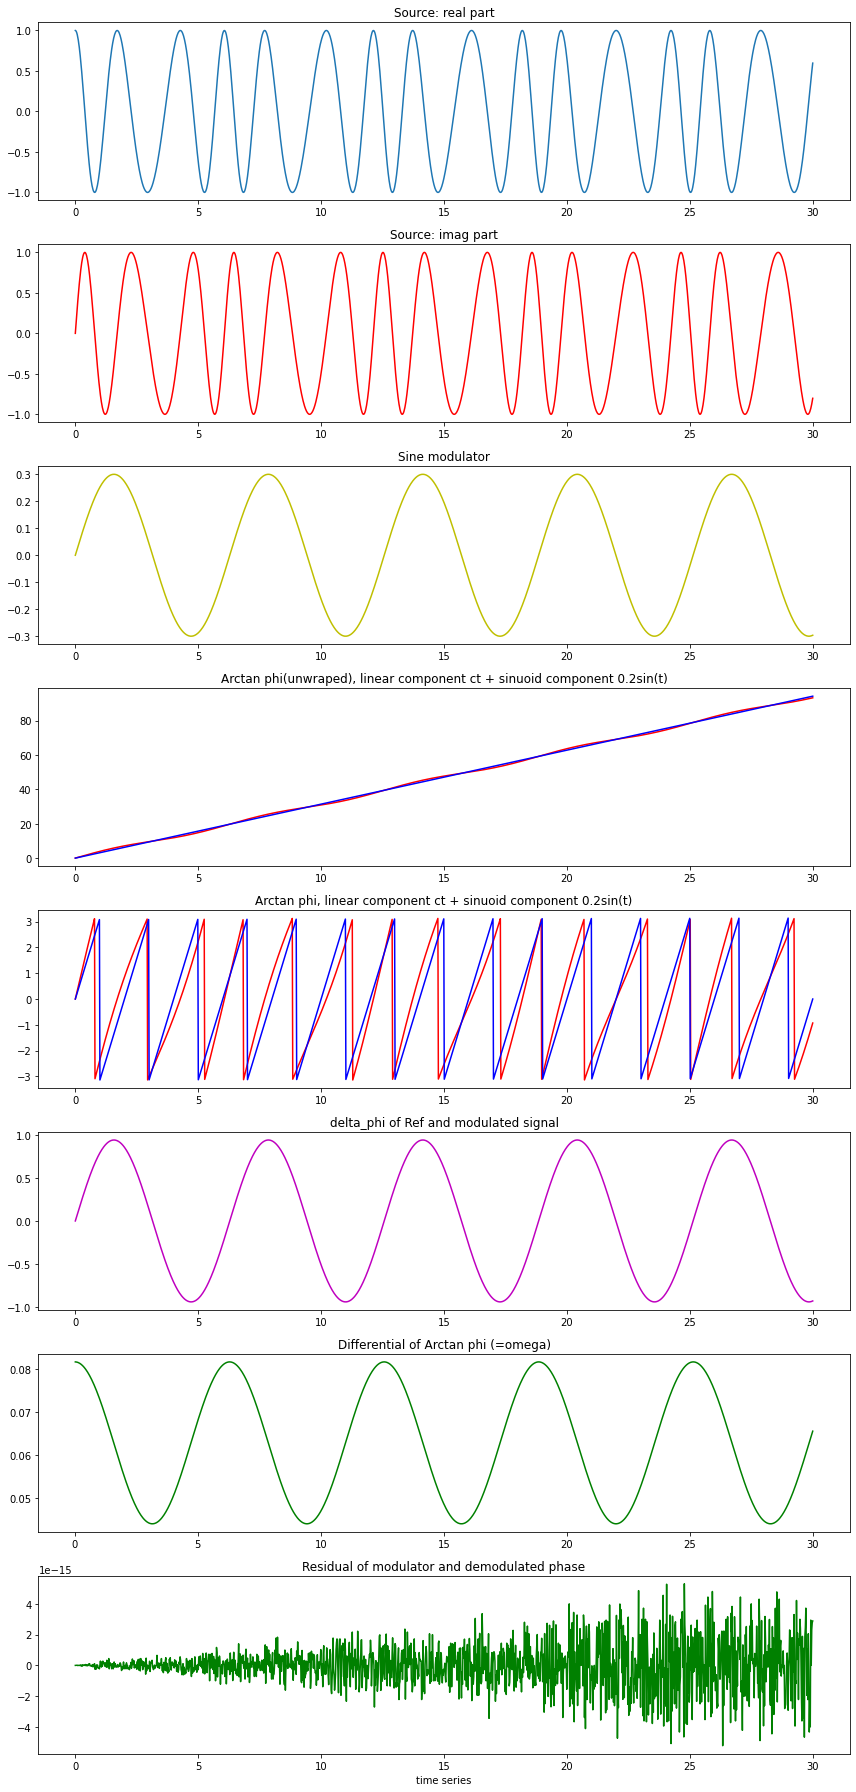

In [71]:
import numpy as np 
from scipy.signal import sweep_poly,hilbert
import matplotlib.pyplot as plt
from matplotlib import gridspec 
# 频率：
f = 1

# 时间轴
t = np.linspace(0, 30, 1500)
# 正弦相位调制
modulator=0.3*np.sin(t*1)
# 正弦相位调制序列
tsin = t+modulator
# 被正弦相位调制的复信号
s_real = np.cos(tsin*np.pi*f)
s_imag = np.sin(tsin*np.pi*f)
# 没有附加相位调制的复信号
r_real = np.cos(t*np.pi*f)
r_imag = np.sin(t*np.pi*f)

## 共绘制7张图
nfig = 8
fig, ax = plt.subplots(figsize=(12, 25))

## 绘制被调制信号实部
plt.subplot(nfig, 1, 1)
plt.plot(t, s_real)
plt.title("Phase modulation")
plt.gca().set_title('Source: real part')

## 绘制被调制信号虚数部
plt.subplot(nfig, 1, 2)
plt.plot(t, s_imag, 'r')
plt.gca().set_title('Source: imag part')

## 绘制用于调制相位的信号
plt.subplot(nfig, 1, 3)
plt.plot(t[:], 0.3*np.sin(t*1), 'y')
plt.gca().set_title('Sine modulator')

## 绘制调制后信号和参考信号直接求arctan2后相角的变化(unwrap后的结果)
plt.subplot(nfig, 1, 4)
plt.plot(t, np.unwrap(np.arctan2(s_imag, s_real)), 'r', linestyle='-') # 红色：调制信号
plt.plot(t, np.unwrap(np.arctan2(r_imag, r_real)), 'b', linestyle='-') # 红色：无调制信号
plt.gca().set_title('Arctan phi(unwraped), linear component ct + sinuoid component 0.2sin(t)')

## 绘制调制后信号和参考信号直接求arctan2后相角的变化(无unwrap的结果)
plt.subplot(nfig, 1, 5)
plt.plot(t, np.arctan2(s_imag, s_real), 'r', linestyle='-') # 红色：调制信号
plt.plot(t, np.arctan2(r_imag, r_real), 'b', linestyle='-') # 红色：无调制信号
plt.gca().set_title('Arctan phi, linear component ct + sinuoid component 0.2sin(t)')

## 绘制调制后信号减去无相位调制的参考信号后的结果
plt.subplot(nfig, 1, 6)
delta_phi=np.arctan2(s_imag, s_real)-np.arctan2(r_imag, r_real)
plt.plot(t[:], np.unwrap(delta_phi), 'm')
plt.gca().set_title('delta_phi of Ref and modulated signal')

## 绘制被调制信号直接求arctan2后相位变化的微分函数（=频率）
plt.subplot(nfig, 1, 7)
dff_phi = np.diff(np.unwrap(np.arctan2(s_imag,s_real)))
plt.plot(t[1:], dff_phi, 'g')
plt.gca().set_title('Differential of Arctan phi (=omega)')

## 绘制被调制信号直接求arctan2后相位变化的微分函数（=频率）
plt.subplot(nfig, 1, 8)
#dff_phi = np.diff(np.unwrap(np.arctan2(s_imag,s_real)))
plt.plot(t[:], np.unwrap(delta_phi)/np.pi-modulator, 'g')
plt.gca().set_title('Residual of modulator and demodulated phase')

# plt.legend()
plt.xlabel('time series')
plt.tight_layout()
plt.show()